# CAS ADS 24-25 - M6 Project
Author: **Marcel Grosjean**

The purpose of this project is to scrape the entire homegate.ch website to collect all rental listings and generate statistics based on the data and train a deep learning model using PyTorch to predict renting prices in Switzerland. The focus will exclusively be on rental houses/apartments, excluding other types of rental listings such as parking spaces, commercial properties, etc. Sales listings will not be considered.

We will only perform the scraping once due to the technical complexity involved. There may be instances where we do not obtain data for all municipalities, and the pricing in the listings may not accurately represent market averages, as we are only capturing data from a single point in time.

This approach will provide a snapshot of the rental market, but we must acknowledge its limitations regarding comprehensiveness and accuracy.

The research question is: **How much am I going to pay for my next appartment ???**

Here are all the steps this project covers:

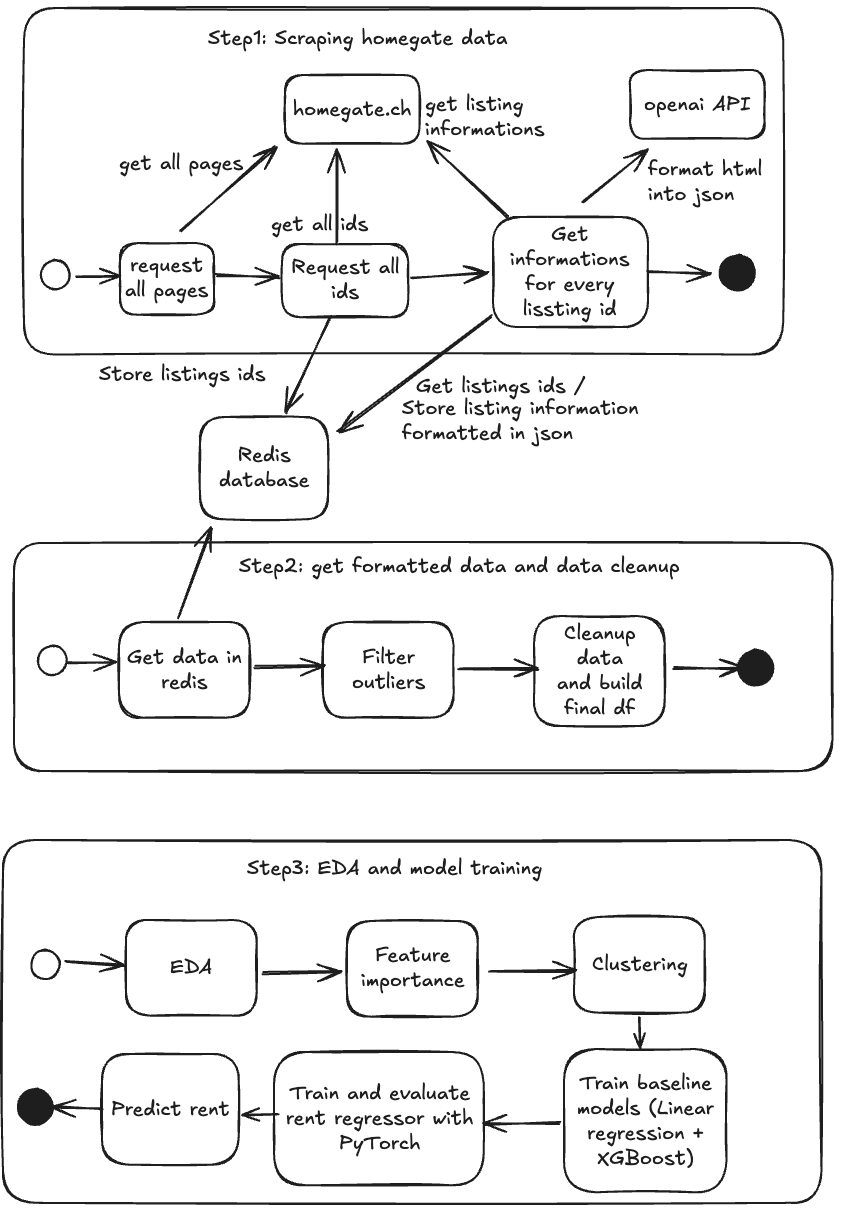



## Step 0: Project setup
First I need to install the necessary packages.

In [3]:
%pip install fake-useragent geopandas seaborn matplotlib beautifulsoup4 bs4 redis openai selenium selenium-wire scikit-learn torch xgboost --break-system-packages > /dev/null


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Don't forger to run an instance of redis with the provided `docker-compose.yml` file with the command:
```bash
docker compose up redis-m6
``` 

Import some libraies:

In [2]:
# python libraries
from collections import Counter, defaultdict 

import subprocess
import time
import math
import random
import json
import re

# requests and beautifulsoup
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

# selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException

# others libraries
import redis
import openai

# ML libraries
import geopandas as gpd
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

from scipy.stats import norm, zscore

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset




Now let's create some helpers function and variables that are needed:

In [ ]:
# OpenAI API key
client = openai.OpenAI(api_key="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

# client for our redis database
redis_client = redis.Redis(host='localhost', port=6380, decode_responses=True)

# Sleep for 10 seconds before each request is ok for cloudflare
def sleep(s = 10):
  time.sleep(s)

ua = UserAgent()
# This function is called at every query to generate a new http query headers
def generate_headers():
  # List of User-Agent strings to rotate
  user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0"
  ]
  headers = {
    "User-Agent": random.choice(user_agents),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "DNT": "1", 
  }
  return headers

# function to create a requests session with retry logic
def create_requests_session_with_retries():
  session = requests.Session()
  retries = Retry(
    total = 5,
    backoff_factor = 1,
    status_forcelist = [500, 502, 503, 504],  # Retry on these status codes
    allowed_methods = ["GET"],
  )
  adapter = HTTPAdapter(max_retries=retries)
  session.mount("http://", adapter)
  session.mount("https://", adapter)
  return session

# Dictionary mapping of canton abbreviations to full names
def get_canton_name(abbreviation):
  canton_map = {
    'AG': 'Aargau', 'AR': 'Appenzell Ausserrhoden', 'AI': 'Appenzell Innerrhoden',
    'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'BE': 'Bern', 'FR': 'Fribourg',
    'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Lucerne',
    'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SZ': 'Schwyz',
    'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SG': 'Sankt Gallen', 'TG': 'Thurgau',
    'TI': 'Ticino', 'UR': 'Uri', 'VS': 'Valais', 'VD': 'Vaud', 'ZG': 'Zug', 'ZH': 'Zürich'
  }

  # Return the corresponding full canton name, or None if not found
  return canton_map.get(abbreviation.upper(), None)

# Step 1: Scraping homegate.ch data

## 1.1 Request all pages
The first step is to go to homegate.ch and get all the links to all the listings. 

Making requests to homegate.ch is quite challenging. It's not possible to do this on Google Colab because Google's IPs are blocked. As a result, I had to run the process on a local Jupyter notebook instance.

Additionally, homegate aggressively applies rate limiting through Cloudflare's proxy. If too many requests are made, Cloudflare blocks access for 12 hours. Homegate.ch also lies about data, but we'll see this in the next steps.

After some trial and error, I found that waiting 10 seconds between each request prevents getting blocked. I also had to make headers rotations as cloudflare blocks if too many same headers are the same. 
Retries strategies had to set up as both cloudflare and homegate.ch often fail for different reasons. 

Scraping the pages itself is difficult as all the pages have complex structure. We can't rely on the ids of the html tags as they often change... That's very annoying !!!

We begin by searching for all the links to the listings for each canton. 

In [ ]:
session = create_requests_session_with_retries()

# this page contains all the cantons (listings) in Switzerland
cantons_url = "https://www.homegate.ch/rent/apartment/switzerland"
cantons_results = session.get(cantons_url, headers=generate_headers())
cantons_results.encoding = 'utf-8'

print(f"Get all the cantons from {cantons_url}")
print(f"Status code: {cantons_results.status_code}")

cantons_page = BeautifulSoup(cantons_results.text)
cantons = []
for arr in cantons_page.select('[class^="row GeoDrillDownLocationsSection_spacer_"]'):
  # get the links to all the cantons
  main_div = arr.find()
  link_tag = main_div.find()

  # region name for homegate.ch
  region_name = link_tag['href'].split("/")[-1]

  # region full name
  canton = link_tag.text

  # we skip regions that are not Swiss canton. It must contain the "Canton" string in its text
  if "Canton" not in canton:
    continue

  # only keep the canton name
  canton = canton.split("Canton")[1].strip()

  cantons.append({
    "canton": canton, 
    "url": {
      "appartments": f"https://www.homegate.ch/rent/apartment/{region_name}/matching-list?ipd=true", 
      "houses": f"https://www.homegate.ch/rent/house/{region_name}/matching-list?ep=1&tab=list&ipd=true"
    }
  })

for canton in cantons:
  print(f"{canton['canton']}")
  print(f"  - Appartments: {canton['url']['appartments']}")
  print(f"  - Houses: {canton['url']['houses']}")

Get all the cantons from https://www.homegate.ch/rent/apartment/switzerland
Status code: 200
Aargau
  - Appartments: https://www.homegate.ch/rent/apartment/canton-aargau/matching-list?ipd=true
  - Houses: https://www.homegate.ch/rent/house/canton-aargau/matching-list?ep=1&tab=list&ipd=true
Appenzell Ausserrhoden
  - Appartments: https://www.homegate.ch/rent/apartment/canton-appenzellausserrhoden/matching-list?ipd=true
  - Houses: https://www.homegate.ch/rent/house/canton-appenzellausserrhoden/matching-list?ep=1&tab=list&ipd=true
Appenzell Innerrhoden
  - Appartments: https://www.homegate.ch/rent/apartment/canton-appenzellinnerrhoden/matching-list?ipd=true
  - Houses: https://www.homegate.ch/rent/house/canton-appenzellinnerrhoden/matching-list?ep=1&tab=list&ipd=true
Basel-City
  - Appartments: https://www.homegate.ch/rent/apartment/canton-baselstadt/matching-list?ipd=true
  - Houses: https://www.homegate.ch/rent/house/canton-baselstadt/matching-list?ep=1&tab=list&ipd=true
Basel-Country


We have got all the pages with listings for all the appartments and houses in Switzerland. 

## 1.2 Request all listing ids

In this part, we're going to get to **ALL** listings ids of homegate.ch for every appartment, house and for every canton.  

For instance, Vaud has 50 pages of appartments. We then make a query to every page and get the id of each listing.
We do it for every appartment, house for every canton. 

Then we store this id in redis with the following structure:
```json
[
  {
    "listing:{listing_id}": null
  }
]
```

We have a redis database that contains all the listings ids, but without value.

This process takes a few hours. 

In [ ]:

start_time = time.time()
session = create_requests_session_with_retries()

for canton in cantons: 
  print(f"############################")

  for url in canton['url'].values():
    print(f"Querying {url} ")
    
    # now we want to find out the number of listings and pages for a given region
    infos_page = session.get(url, headers=generate_headers())
    infos_page.encoding = 'utf-8'
    infos = BeautifulSoup(infos_page.text)

    # number of listings for this region
    # Find all elements matching the class pattern
    elements = infos.find_all(class_=re.compile(r"^ResultListHeader_locations_bold_"))

    # Check if at least one element was found
    if elements:
      nb = int(elements[0].text.split(' ')[0])
    else:
      print("No listings found for this region")
      continue

    # number of pages  for this listing
    pages = math.ceil(nb/20)
    if pages > 50: # we can handle at most 50 pages with the homegate ui
      pages = 50

    print(f"Query canton: {canton['canton']}")
    print(f"Pages: {pages}, listings: {nb}")
    print(f"Quering page: ", end='')

    # Query all the listings, page by page. 
    # There might be up to 50 pages of listings.
    for i in range(1, pages+1):
      print(f"{i}, ", end='')

      url = f"{url}&ep={i}" # query page by page
      listings = session.get(url, headers=generate_headers())
      listings.encoding = 'utf-8'
      listings = BeautifulSoup(listings.text)

      # cards contains the informations about a listing
      cards = listings.find_all("a", class_="HgCardElevated_content_uir_2")
      for card in cards:
        # we will get the listing id from the href
        # can can go directly to the listing with the url
        # https://www.homegate.ch/rent/{listing_id}
        listing_id = card.get("href").split("/")[-1]

        # Ok we have the id of the listing but we won't query the listing yet.
        # We store the id in redis with a null payload if it does not already exist
        redis_key = f"listing:{listing_id}"
        # Use SETNX to add the key only if it doesn't exist
        redis_client.setnx(redis_key, "")

      #break
      # sleep before querying the next page
      sleep()

    print(f"done for canton {canton['canton']}")

    #break
    sleep()

print()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Done in {elapsed_time:.2f} seconds.")

############################
Querying https://www.homegate.ch/rent/apartment/canton-aargau/matching-list?ipd=true 
Query canton: Aargau
Pages: 50, listings: 1297
Quering page: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, done for canton Aargau
Querying https://www.homegate.ch/rent/house/canton-aargau/matching-list?ep=1&tab=list&ipd=true 
Query canton: Aargau
Pages: 5, listings: 85
Quering page: 1, 2, 3, 4, 5, done for canton Aargau
############################
Querying https://www.homegate.ch/rent/apartment/canton-appenzellausserrhoden/matching-list?ipd=true 
Query canton: Appenzell Ausserrhoden
Pages: 8, listings: 148
Quering page: 1, 2, 3, 4, 5, 6, 7, 8, done for canton Appenzell Ausserrhoden
Querying https://www.homegate.ch/rent/house/canton-appenzellausserrhoden/matching-list?ep=1&tab=list&ipd=true 
Query canton: Appenzell Ausserrhoden
Pa

## 2.3 Get all the listings details
We're going to get all the listings that have empty payload. Here is the process we follow:

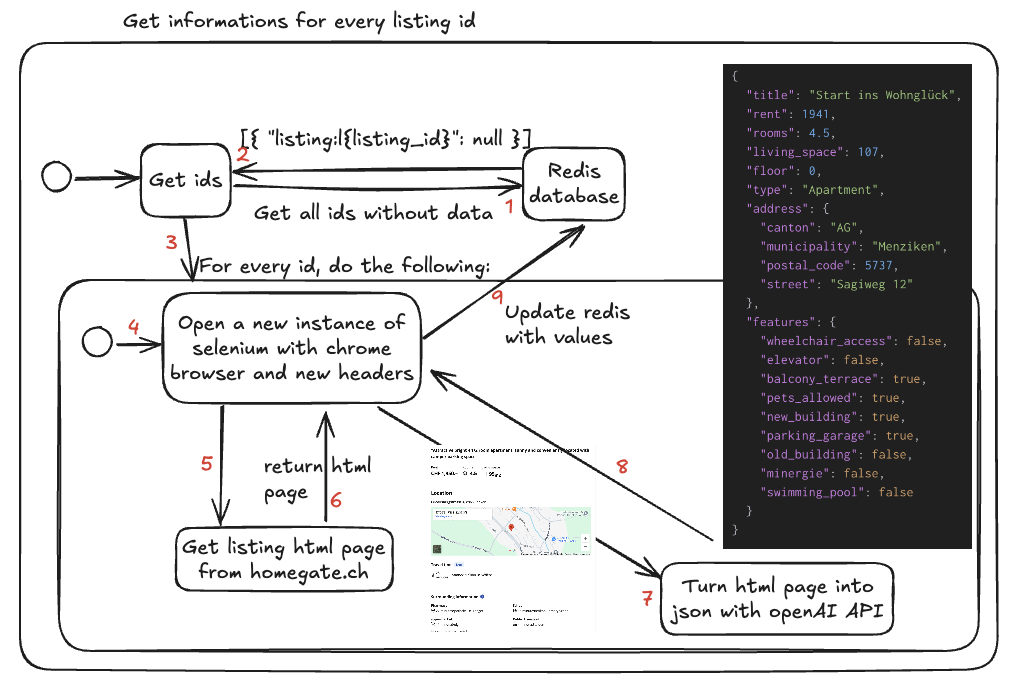

I could not use the request module for this part. I found out late in the project that homegate.ch is lying about the data if I query the page with the python requests package !!!!!

Indeed, even if managed to bypass both rate limiter of cloudflare and homegate, homegate.ch somehow detect that I am using python requests module and then lie on the web page. 
The pages returned are exactly the same as if you had visited it with a browser. The only difference is that they change the renting price and the living space.

The most important data are then fake and not usable for the project! 

To bypass this limitation, i had to use Selenium with ChromeBrowser driver. For each listing I had to:
- open a brand new chrome browser with Selenium
  - the browser can not be headless
  - its headers have to be different at each query
- query the listing page and wait it has fully loaded
- extract the html informations in the listing
- send the listing to chatgpt through the openai API
  - make sure that chatgpt extract the right informations in the right format
  - clean and parse the response
- close the chrome instance
- save the data in redis
- repeat

This process takes **DAYS**.

In [3]:
# Chrome and selenium options
chrome_options = Options()
# Chrome can't be headless otherwise homegate will detect that !!!
#chrome_options.add_argument("--headless")
#chrome_options.add_argument("--no-startup-window")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--start-minimized")

start_time = time.time()
i = 0

# lopp through all the keys in redis
for key in redis_client.scan_iter("listing:*"):
  value = redis_client.get(key)
  
  # we only process the keys that have an empty value
  if value != "":
    continue

  listing_id = key.split(":")[-1]
  print(f"Query listing: {listing_id}")

  # query the listing page for each listing id
  # we're going to extract only the text needed for the analysis
  # we're going to use selenium, create, lunch and quit a whole new browser for each listing
  # otherwise homegate.ch will send us bad data... -______-
  listing_url = f"https://www.homegate.ch/rent/{listing_id}"
  print(f"Query listing : {listing_url}")

  # lunch a new chrome browser and go to the listing page
  service = Service('/opt/homebrew/bin/chromedriver')
  driver = webdriver.Chrome(service=service, options=chrome_options)
  driver.request_interceptor = lambda request: [request.headers.update(generate_headers())]

  # Move the window off-screen using AppleScript
  subprocess.run(['osascript', '-e', 'tell application "Google Chrome" to set minimized of front window to true'])
  # Go to the listing page
  driver.get(listing_url)

  # Wait for the page to load and the desired element to be present
  try:
    WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.CLASS_NAME, "hg-listing-details"))
    )
  except TimeoutException:
    # if we get here it means that the page is no longer available
    print("Timed out waiting for page to load")
    driver.quit()
    redis_client.delete(key) # remove the listing
    sleep()
    continue

  # Get the page source and parse it with BeautifulSoup
  listing_page = driver.page_source
  listing = BeautifulSoup(listing_page, 'html.parser')
  listing = listing.find_all(class_="hg-listing-details")[0].text

  ### EXTRACTING THE DATA WITH CHATGPT ###
  prompt = f"""
  You are an assistant that extracts information from an unstructured real estate listing and converts it into a structured JSON format.
  
  Here is the JSON structure you must follow:
  {{
      "title": "string (NO_TITLE if missing)",
      "rent": int (0 if missing),
      "rooms": float (0 if missing),
      "living_space": int (0 if missing, can also be called "space living" or "surface" or "floor space" in the listing),
      "floor": int (0 if missing),
      "type": "Apartment" | "House",
      "address": {{
        "canton": "string (2 uppercase letters)",
        "municipality": "string",
        "postal_code": int,
        "street": "string"
      }},
      "features": {{
        "wheelchair_access": boolean,
        "elevator": boolean,
        "balcony_terrace": boolean,
        "pets_allowed": boolean,
        "new_building": boolean,
        "parking_garage": boolean,
        "old_building": boolean,
        "minergie": boolean,
        "swimming_pool": boolean
      }}
  }}
  
  You have to decide if the listing is either apartment or house. 
  If you can't find the canton name in the listing, try to find out the canton name based on the postal code and if you can't, use "NO_CANTON".
  All features are false by default and must be set to true if they appear in the listing.
  
  Here is the real estate listing:
  =========
  {listing}
  =========
  
  Return only the JSON object without any additional text.
  The JSON object must be directly parsable by python without any modifications.
  """
  
  
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {"role": "system", "content": "You are an assistant specialized in data extraction."},
      {"role": "user", "content": prompt}
    ]
  )
  
  structured_data = response.choices[0].message.content.strip()
  # Remove Markdown code block delimiters if present
  if structured_data.startswith("```json"):
    structured_data = structured_data[len("```json"):].strip()
  if structured_data.endswith("```"):
    structured_data = structured_data[:-len("```")].strip()
    
  # suppress control characters
  structured_data = re.sub(r"[\x00-\x1F\x7F]", "", structured_data)
  
  structured_data = json.loads(structured_data)

  print(structured_data)
  
  # Save the structured data in redis
  redis_client.set(key, json.dumps(structured_data))

  # procedure at the end of each listing page request
  driver.quit() # we need to close the browser each time
  i += 1
  print()
  sleep()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Done in {elapsed_time:.2f} seconds.")
print(f"Total listings processed: {i}")

Done in 5.78 seconds.
Total listings processed: 0


In redis we have all the listings in the following format: 
```json
[
  {
    "listing:{listing_od}": {
      "title": "string (NO_TITLE if missing)",
      "rent": "int (0 if missing)",
      "rooms": "float (0 if missing)",
      "living_space": "int (0 if missing",
      "floor": "int (0 if missing)",
      "type": "Apartment | House",
      "address": {
        "canton": "string",
        "municipality": "string",
        "postal_code": "int (0 if missing)",
        "street": "string"
      },
      "features": {
        "wheelchair_access": boolean,
        "elevator": boolean,
        "balcony_terrace": boolean,
        "pets_allowed": boolean,
        "new_building": boolean,
        "parking_garage": boolean,
        "old_building": boolean,
        "minergie": boolean,
        "swimming_pool": boolean
      }
    } 
  }
]
```

## Step 2: Get formatted data from Redis, cleanup and build the dataframe
In this part we're going to build the final dataframe that will be used for training. 

We have a redis database with all the "raw" data from the listing in json format.

In order to build the final dataframe we need to:
- get all the listings that follow the requirements:
  - have data 
  - rent is 600 or more (I found that too many listing with rent lower than 600.- have mistakes)
  - data are correctly formatted
- for each listing we make sure that: 
  - They have all the required values (the average is applied if there are missing values)
  - all municipalities must have the same name (some municipalities may have differents name in different languages)
- we then filter the outliers using the IQR method
  - rich people may rent very expensive appartments
- store all the remaining data in a dataframe called `df`


In [4]:
# Theses are the headers that we're going to use for the dataframe
df_headers = [
  "type", 
  "rooms",
  "living_space",
  "floor",
  "canton",
  "municipality",
  "postal_code", 
  "wheelchair_access",
  "elevator",
  "balcony_terrace",
  "pets_allowed",
  "new_building",
  "parking_garage",
  "old_building",
  "minergie",
  "swimming_pool",
  "rent",
]
df = pd.DataFrame(columns=df_headers)

# we loop through all the listings in redis
for key in redis_client.scan_iter("listing:*"):
  value = redis_client.get(key)

  # we only process the keys that have a value
  if value == "":
    continue
  
  # parse the values from redis
  data = json.loads(value)
  
  # Skip listings with missing data or low rent
  if data["address"]["canton"] == "NO_CANTON" or data["rent"] < 600:
    continue

  # Extract the relevant fields
  row = {
    "type": data["type"],
    "rooms": data["rooms"],
    "living_space": data["living_space"],
    "floor": data["floor"],
    "canton": data["address"]["canton"],
    "municipality": data["address"]["municipality"],
    "postal_code": data["address"]["postal_code"],
    "wheelchair_access": data["features"]["wheelchair_access"],
    "elevator": data["features"]["elevator"],
    "balcony_terrace": data["features"]["balcony_terrace"],
    "pets_allowed": data["features"]["pets_allowed"],
    "new_building": data["features"]["new_building"],
    "parking_garage": data["features"]["parking_garage"],
    "old_building": data["features"]["old_building"],
    "minergie": data["features"]["minergie"],
    "swimming_pool": data["features"]["swimming_pool"],
    "rent": data["rent"],
  }
  
  # Append the row to the DataFrame
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

# OK now we need to do some data cleaning

# there are missing values for the rooms
# so we're going to compute the average room for apartments and houses and attribute it to the missing values
avg_rooms_apartment = df[df["type"] == "Apartment"]["rooms"].replace(0, np.nan).mean()
avg_rooms_house = df[df["type"] == "House"]["rooms"].replace(0, np.nan).mean()
df.loc[(df["type"] == "Apartment") & (df["rooms"] == 0), "rooms"] = avg_rooms_apartment
df.loc[(df["type"] == "House") & (df["rooms"] == 0), "rooms"] = avg_rooms_house
df["rooms"] = df["rooms"].apply(lambda x: round(x * 2) / 2)

# we're doing the same for the living space
avg_living_space_apartment = df[df["type"] == "Apartment"]["living_space"].replace(0, np.nan).mean()
avg_living_space_house = df[df["type"] == "House"]["living_space"].replace(0, np.nan).mean()
df.loc[(df["type"] == "Apartment") & (df["living_space"] < 10), "living_space"] = avg_living_space_apartment
df.loc[(df["type"] == "House") & (df["living_space"] < 10), "living_space"] = avg_living_space_house
df["living_space"] = df["living_space"].apply(lambda x: round(x))

# a municipality may have multiple names according to the language
# we only want to keep 1 by applying the following algorithm
# - Get all distinct postal codes.
# - For each postal code, get all the different municipalities.
# - Count how many times each municipality appears for a given postal code.
# - Take the municipality that appears the most often.
# - Apply this municipality to all entries with the same postal code.

# Get all distinct postal codes
postal_codes = df["postal_code"].unique()
# Create a dictionary to store the most common municipality for each postal code
most_common_municipality = {}
# For each postal code, get all the different municipalities and count their occurrences
for postal_code in postal_codes:
  municipalities = df[df["postal_code"] == postal_code]["municipality"]
  most_common = Counter(municipalities).most_common(1)[0][0]
  most_common_municipality[postal_code] = most_common
# Apply the most common municipality to all entries with the same postal code
df["municipality"] = df.apply(lambda row: most_common_municipality[row["postal_code"]], axis=1)
df["canton"] = df["canton"].apply(get_canton_name)

# Remove the outliers using the Z-score method
#df["rent"] = pd.to_numeric(df["rent"], errors='coerce')
#df["zscore"] = zscore(df["rent"])
#df = df[(df["zscore"] >= -3) & (df["zscore"] <= 3)]
#df = df.drop(columns=["zscore"])

# Remove the outliers using the IQR method
df["rent"] = pd.to_numeric(df["rent"], errors='coerce')
Q1 = df["rent"].quantile(0.25)
Q3 = df["rent"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["rent"] >= lower_bound) & (df["rent"] <= upper_bound)]

# display the final dataframe
df

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_64080/1398306973.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_64080/1398306973.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_living_space_apartment = df[df["type"] == "Apartment"]["living_space"].replace(0, np.nan).mean()
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_64080/1398306973.py:74: FutureWarning: 

,type,rooms,living_space,floor,canton,municipality,postal_code,wheelchair_access,elevator,balcony_terrace,pets_allowed,new_building,parking_garage,old_building,minergie,swimming_pool,rent
0,Apartment,3.5,88,1,Basel-Stadt,Niederdorf,4435,False,False,True,True,False,True,False,False,False,1370
1,Apartment,2.5,77,0,Zürich,Rüti,8630,True,True,True,False,True,True,False,False,False,2100
2,Apartment,3.5,88,2,Bern,Biel/Bienne,2502,False,False,True,False,False,False,False,False,False,1350
3,Apartment,4.5,107,0,Aargau,Menziken,5737,False,False,True,True,True,True,False,False,False,1941
5,Apartment,3.0,88,2,Neuchâtel,Le Locle,2400,False,False,False,False,False,False,False,False,False,970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13746,Apartment,3.5,76,1,Fribourg,Siviriez,1678,False,True,True,False,False,False,False,False,False,1790
13747,Apartment,4.0,88,6,Neuchâtel,La Chaux-de-Fonds,2300,False,True,True,False,False,False,False,False,False,1610
13748,Apartment,3.5,93,1,Zürich,Zürich,8048,False,True,True,True,True,True,False,False,False,3760
13749,Apartment,6.0,147,1,Neuchâtel,La Chaux-de-Fonds,2300,False,False,True,False,False,False,True,False,False,1950


## Step 3: EDA, Clustering, Model training and prediction

## 3.1: EDA
We're going to take a look at our data.
### 3.1.1 Number of listings for appartments and houses in each canton 

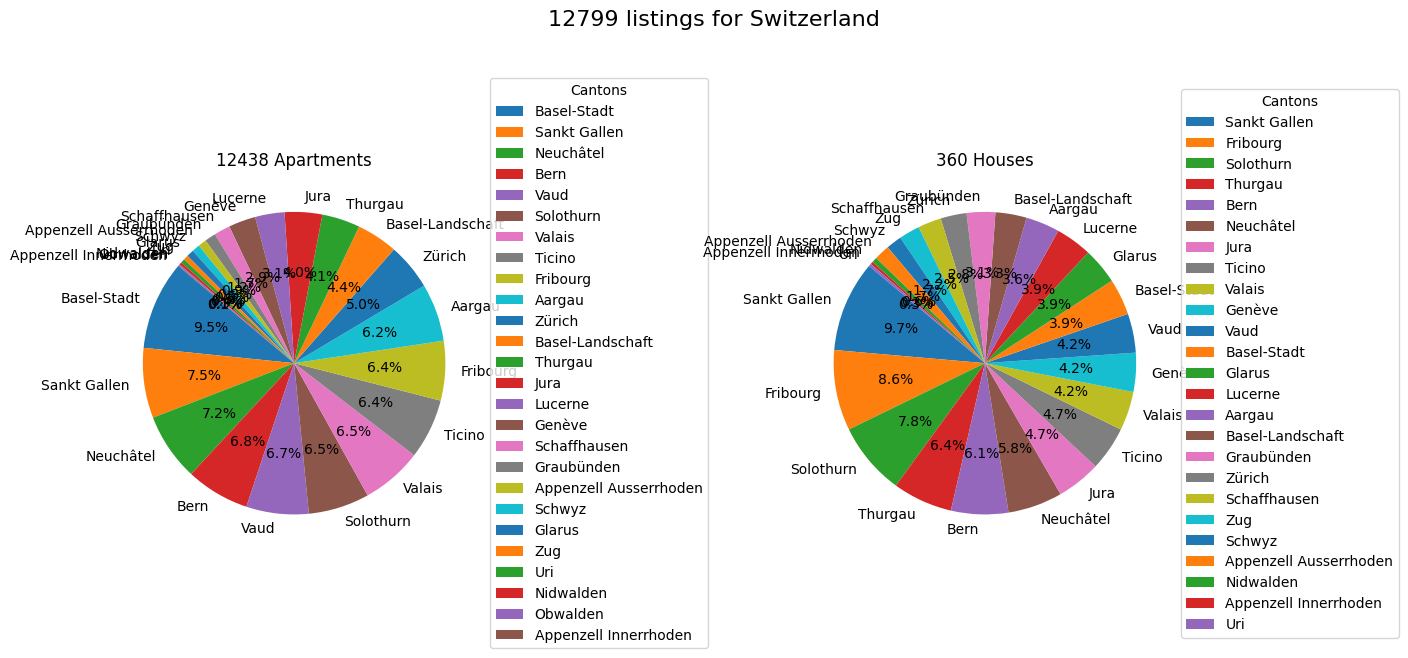

In [30]:
# Filter the DataFrame for apartments and houses
df_apartments = df[df["type"] == "Apartment"]
df_houses = df[df["type"] == "House"]

# Count the number of listings by canton for apartments and houses
count_apartments_by_canton = df_apartments["canton"].value_counts()
count_houses_by_canton = df_houses["canton"].value_counts()

# Create a figure with two subplots (pie charts)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for apartments
axes[0].pie(count_apartments_by_canton, labels=count_apartments_by_canton.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f'{len(df_apartments)} Apartments')

# Pie chart for houses
axes[1].pie(count_houses_by_canton, labels=count_houses_by_canton.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f'{len(df_houses)} Houses')

# Add a legend
axes[0].legend(count_apartments_by_canton.index, title="Cantons", bbox_to_anchor=(1, 0.5), loc="center left")
axes[1].legend(count_houses_by_canton.index, title="Cantons", bbox_to_anchor=(1, 0.5), loc="center left")
fig.suptitle(f'{len(df)} listings for Switzerland', fontsize=16)
# Display the plot
plt.tight_layout()
plt.show()

### 3.1.2 Prices distribution by type of accomodation

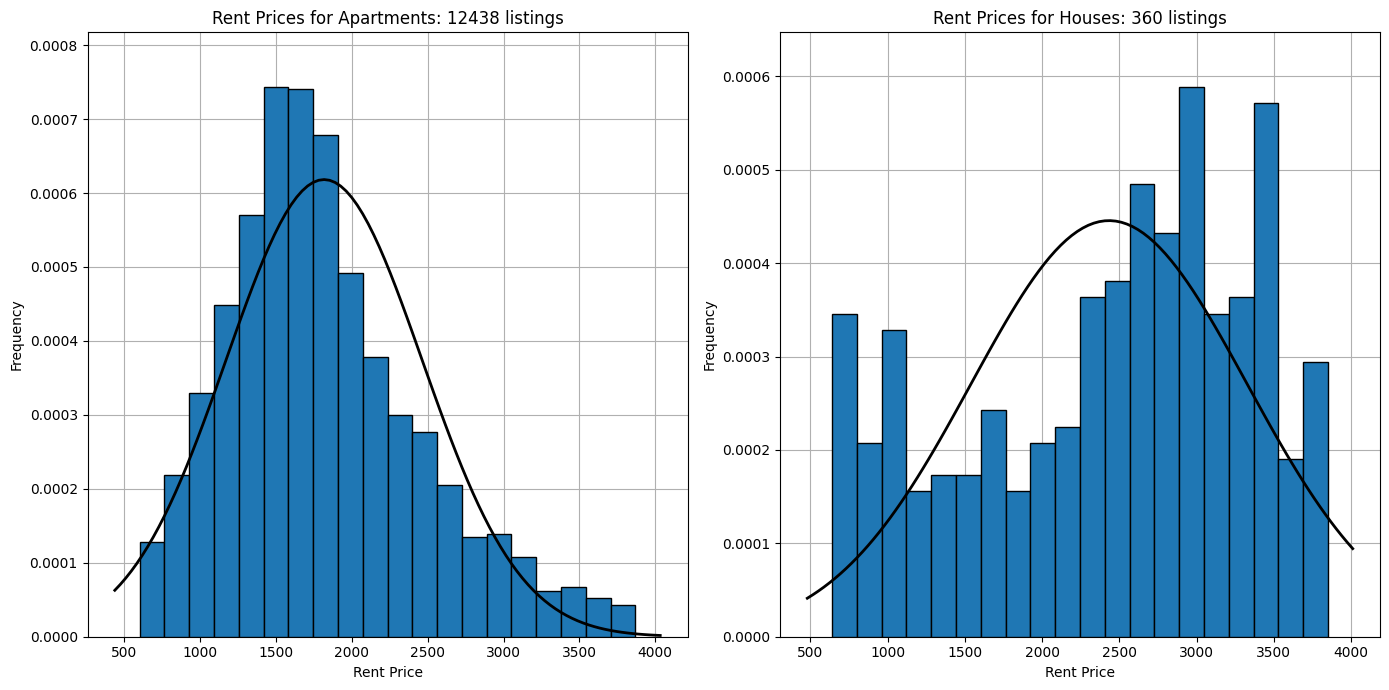

In [31]:
# Filter the cleaned DataFrame for apartments and houses
df_apartments = df[df["type"] == "Apartment"]
df_houses = df[df["type"] == "House"]

# Create a figure with two subplots (histograms)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Histogram for apartments
axes[0].grid(True, zorder=0)
axes[0].set_title(f'Rent Prices for Apartments: {len(df_apartments)} listings')
axes[0].set_xlabel('Rent Price')
axes[0].set_ylabel('Frequency')
n, bins, patches = axes[0].hist(df_apartments["rent"], bins=20, edgecolor='black', zorder=10, density=True)

# Fit a normal distribution to the data
mu, std = norm.fit(df_apartments["rent"])
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[0].plot(x, p, 'k', linewidth=2, zorder=15)
axes[0].set_ylim(0, max(n) * 1.1)

# Histogram for houses
axes[1].grid(True, zorder=0)
axes[1].set_title(f'Rent Prices for Houses: {len(df_houses)} listings')
axes[1].set_xlabel('Rent Price')
axes[1].set_ylabel('Frequency')
n, bins, patches = axes[1].hist(df_houses["rent"], bins=20, edgecolor='black', zorder=10, density=True)

# Fit a normal distribution to the data
mu, std = norm.fit(df_houses["rent"])
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[1].plot(x, p, 'k', linewidth=2, zorder=15)
axes[1].set_ylim(0, max(n) * 1.1)

# Display the plot
plt.tight_layout()
plt.show()

### 3.1.3 Prices distrution by canton

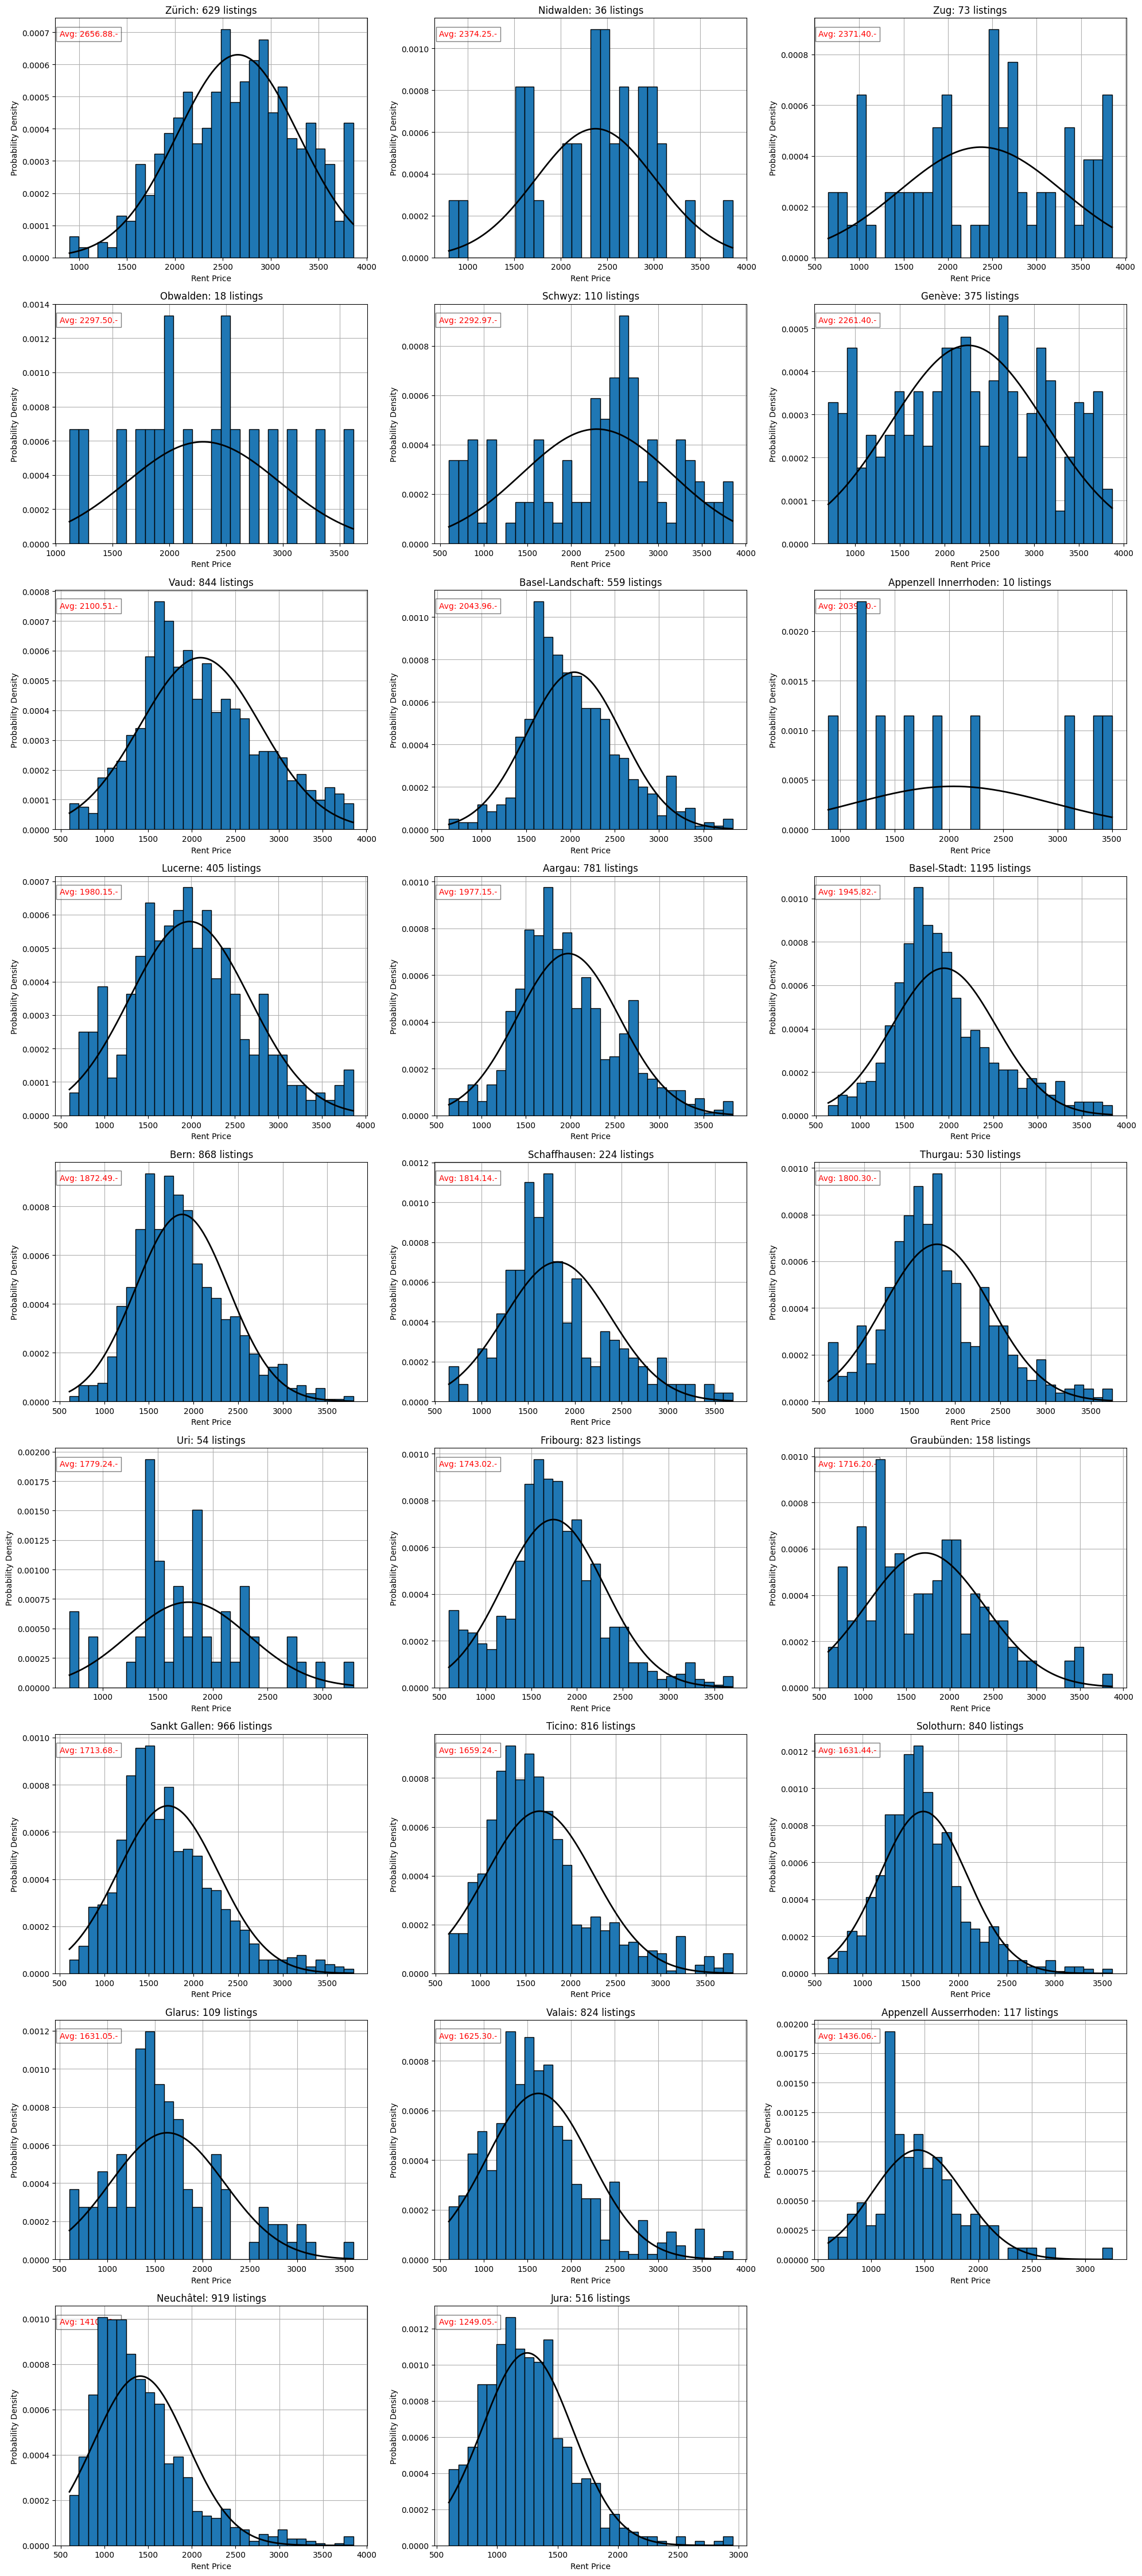

In [ ]:
# Compute the average rent per canton and sort by average rent in descending order
avg_rent_df = df.groupby('canton')['rent'].mean().reset_index()
avg_rent_df.columns = ['canton', 'average_rent']
avg_rent_df = avg_rent_df.sort_values('average_rent', ascending=False)

# Get the sorted list of cantons
sorted_cantons = avg_rent_df['canton'].values

# Prepare a grid of subplots
num_cantons = len(sorted_cantons)
cols = 3  # Number of columns in the subplot grid
rows = (num_cantons // cols) + (num_cantons % cols > 0)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, canton in enumerate(sorted_cantons):
  ax = axes[i]
  
  # Extract data for this canton
  df_canton = df[df["canton"] == canton]
  
  # Plot histogram with density=True for bell-curve overlay
  counts, bin_edges, _ = ax.hist(
      df_canton["rent"], bins=30, edgecolor='black',
      zorder=10, density=True
  )
  
  # Fit a normal distribution and plot the bell curve
  mu, std = norm.fit(df_canton["rent"])
  
  # If the standard deviation is zero, skip plotting the bell curve
  if std == 0:
      ax.set_title(f'{canton} (std = 0, no curve)')
      continue
  
  x = np.linspace(bin_edges[0], bin_edges[-1], 200)
  pdf_vals = norm.pdf(x, mu, std)
  ax.plot(x, pdf_vals, 'k', linewidth=2, zorder=15)
  
  # Add a label for the average rent
  avg_rent = avg_rent_df[avg_rent_df['canton'] == canton]['average_rent'].values[0]
  ax.annotate(f'Avg: {avg_rent:.2f}.-', xy=(0.2, 0.95), xycoords='axes fraction',
              ha='right', va='top', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.5, zorder=450))
  
  # Set labels and grid
  ax.set_title(f'{canton}: {len(df_canton)} listings')
  ax.set_xlabel('Rent Price')
  ax.set_ylabel('Probability Density')
  ax.grid(True, zorder=0)

# Remove any remaining empty subplots if we have fewer cantons than subplot cells
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.1.4 Rent average for each canton

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/2361409179.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_rent_df['canton'], rotation=45, ha='right')


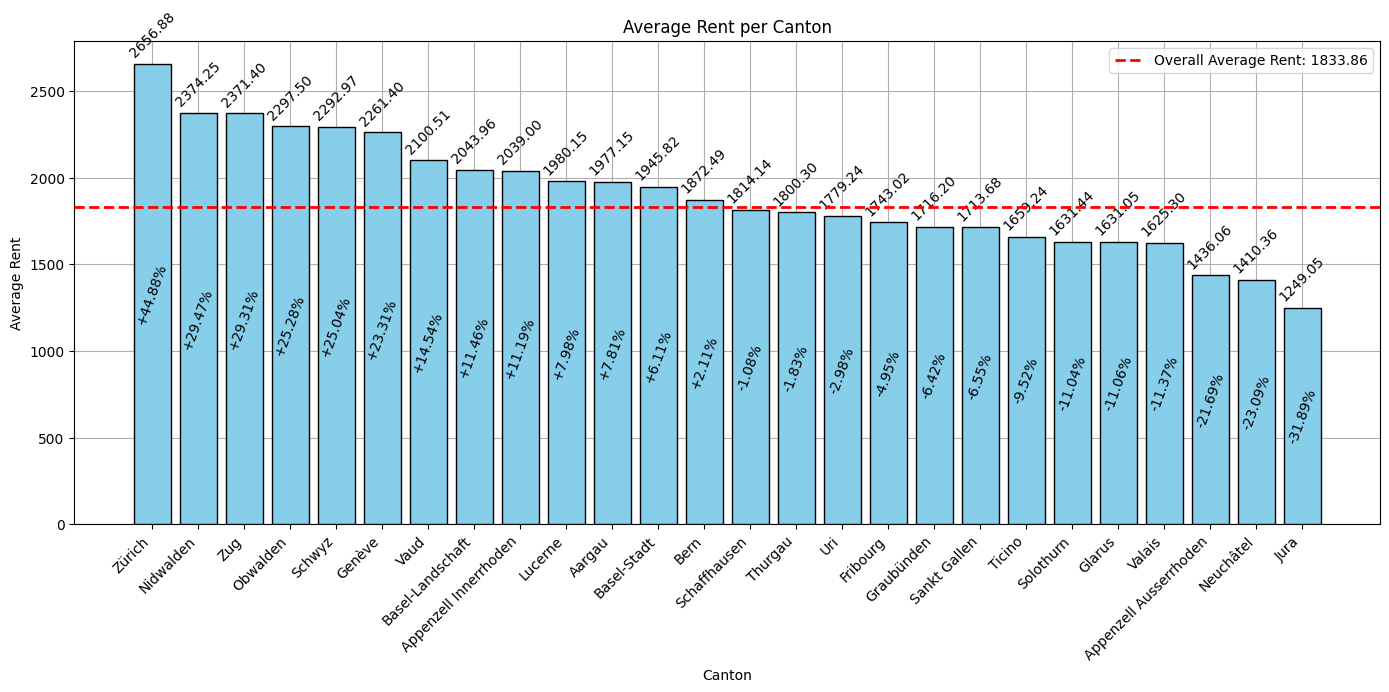

In [34]:
# Compute the average rent per canton
avg_rent_df = df.groupby('canton')['rent'].mean().reset_index()
avg_rent_df.columns = ['canton', 'average_rent']

# Sort by average_rent in descending order
avg_rent_df = avg_rent_df.sort_values('average_rent', ascending=False)

# Compute the overall average rent
overall_avg_rent = df["rent"].mean()

# Plot the histogram
fig, ax = plt.subplots(figsize=(14, 7))

# Create the histogram
bars = ax.bar(avg_rent_df['canton'], avg_rent_df['average_rent'], color='skyblue', edgecolor='black', zorder=10)

# Add the average rent value on top of each bar and the percentage difference in the center
for bar in bars:
  height = bar.get_height()
  percentage_diff = ((height - overall_avg_rent) / overall_avg_rent) * 100
  ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(0, 3),  # 3 points vertical offset
              textcoords="offset points",
              ha='center', va='bottom', rotation=45)
  ax.annotate(f'{percentage_diff:+.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height / 2),
              xytext=(0, 0),  # No offset
              textcoords="offset points",
              ha='center', va='center', fontsize=10, color='black', rotation=70, zorder=40)

# Add a horizontal line for the overall average rent
ax.axhline(overall_avg_rent, color='red', linestyle='--', linewidth=2, label=f'Overall Average Rent: {overall_avg_rent:.2f}', zorder=20)

# Set titles and labels
ax.set_title('Average Rent per Canton')
ax.set_xlabel('Canton')
ax.set_ylabel('Average Rent')
ax.grid(True, zorder=0)

# Rotate the x-axis labels
ax.set_xticklabels(avg_rent_df['canton'], rotation=45, ha='right')

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

### 3.1.5 Rent heatmmap

There are 1536 distinct municipalities.


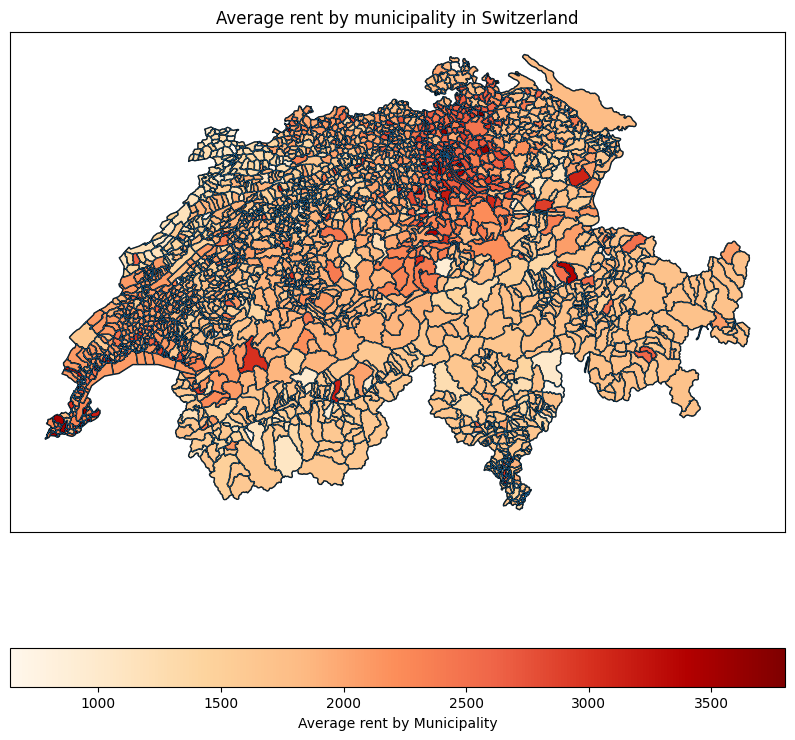

In [41]:
# Extract the list of unique municipalities from the DataFrame
municipalities = df["municipality"].unique()

# Compute the average rent for each municipality
rents_avg_per_municipality = []
for municipality in municipalities:
  rents = df[df["municipality"] == municipality]["rent"]
  average = rents.mean()
  rents_avg_per_municipality.append(average)

print(f"There are {len(municipalities)} distinct municipalities.")

# Load Switzerland municipalities shapefile (replace the URL with a local or valid online shapefile for municipalities)
shape_file = 'https://static.grosjean.io/cas/CHE_adm3.shp'
switzerland = gpd.read_file(shape_file)

# Create a DataFrame with the average rent data for municipalities
rent_data_municipality = {
  'municipality': municipalities,
  'average_rent': rents_avg_per_municipality
}
rent_df_municipality = pd.DataFrame(rent_data_municipality)

# Merge the average rent data with the shapefile data using a left join
switzerland = switzerland.merge(rent_df_municipality, left_on='NAME_3', right_on='municipality', how='left')

# Compute the average rent for each canton
cantons = df["canton"].unique()
rents_avg_per_canton = []
for canton in cantons:
  rents = df[df["canton"] == canton]["rent"]
  average = rents.mean()
  rents_avg_per_canton.append(average)

# Create a DataFrame with the average rent data for cantons
rent_data_canton = {
  'canton': cantons,
  'average_rent_canton': rents_avg_per_canton
}
rent_df_canton = pd.DataFrame(rent_data_canton)

# Merge the average rent data for cantons with the shapefile data
switzerland = switzerland.merge(rent_df_canton, left_on='NAME_1', right_on='canton', how='left')

# Fill missing average rent values for municipalities with the average rent of their respective cantons
switzerland['average_rent'] = switzerland.apply(
  lambda row: row['average_rent'] if pd.notna(row['average_rent']) else row['average_rent_canton'], axis=1
)

# Drop the temporary canton average rent column
switzerland = switzerland.drop(columns=['average_rent_canton'])

# Plotting the municipalities with average rent data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
switzerland.boundary.plot(ax=ax, linewidth=0.2)  # Plot boundaries
switzerland.plot(column='average_rent', ax=ax, legend=True,
                 legend_kwds={'label': "Average rent by Municipality",
                              'orientation': "horizontal"},
                 cmap='OrRd', edgecolor='black')

# Title and show plot
plt.xticks([])
plt.yticks([])
plt.title('Average rent by municipality in Switzerland')
plt.show()

### 3.1.6 Most expensive cities to live in

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/2600665074.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_canton['city_canton'], rotation=45, ha='right')
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/2600665074.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_canton['city_canton'], rotation=45, ha='right')
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/2600665074.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_canton['city_canton'], rotation=45, ha='right')
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/2600665074.py:44: UserWarning: set_ticklabels() should only be used with a fixed numbe

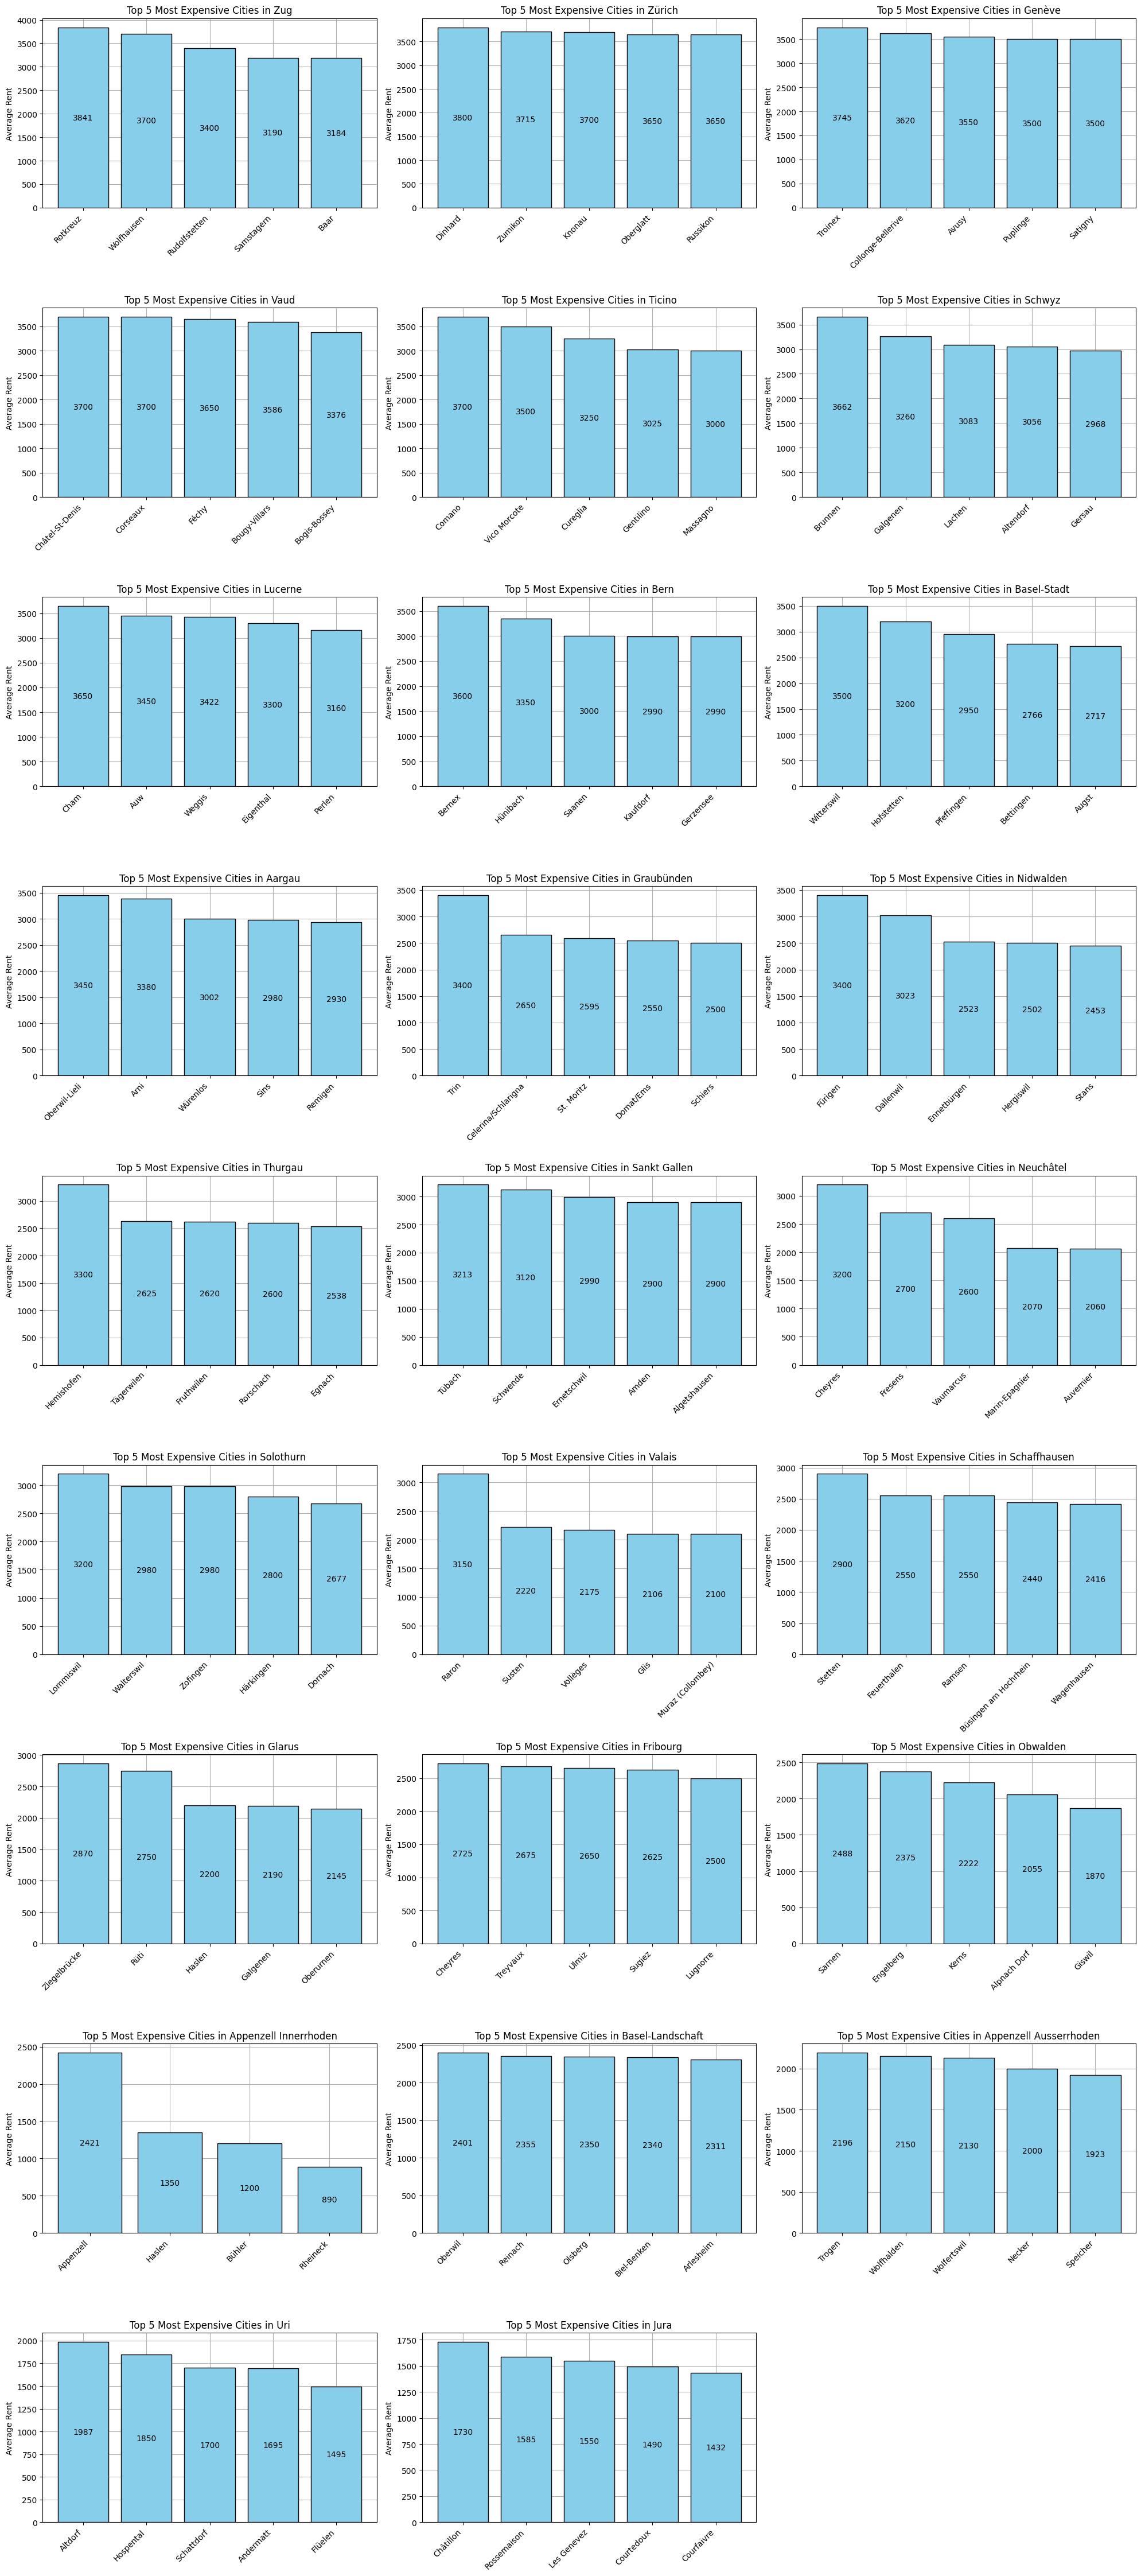

In [37]:
avg_rent_city_df = df.groupby(['municipality', 'canton'])['rent'].mean().reset_index()
avg_rent_city_df.columns = ['municipality', 'canton', 'average_rent']

# Sort by average_rent in descending order
avg_rent_city_df = avg_rent_city_df.sort_values('average_rent', ascending=False)

# Get the list of unique cantons sorted by the highest average rent of their cities
sorted_cantons = avg_rent_city_df.groupby('canton')['average_rent'].max().sort_values(ascending=False).index

# Prepare a grid of subplots
num_cantons = len(sorted_cantons)
cols = 3  # Number of columns in the subplot grid
rows = (num_cantons // cols) + (num_cantons % cols > 0)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, canton in enumerate(sorted_cantons):
  ax = axes[i]
  
  # Extract data for the current canton and select the top 5 most expensive cities
  df_canton = avg_rent_city_df[avg_rent_city_df["canton"] == canton].head(5)
  
  # Create a new column for the x-labels combining city and canton names
  df_canton['city_canton'] = df_canton['municipality']
  
  # Create the bar plot
  bars = ax.bar(df_canton['city_canton'], df_canton['average_rent'], color='skyblue', edgecolor='black', zorder=20)
  
  # Add the average rent value in the middle of each bar
  for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                xytext=(0, 0),  # No offset
                textcoords="offset points",
                ha='center', va='center', fontsize=10, color='black', zorder=30)
  
  # Set titles and labels
  ax.set_title(f'Top 5 Most Expensive Cities in {canton}')
  ax.set_ylabel('Average Rent')
  ax.grid(True, zorder=0)
  
  # Rotate the x-axis labels
  ax.set_xticklabels(df_canton['city_canton'], rotation=45, ha='right')

# Remove any remaining empty subplots if we have fewer cantons than subplot cells
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.1.7 Others features

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/3888450960.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_98387/3888450960.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')


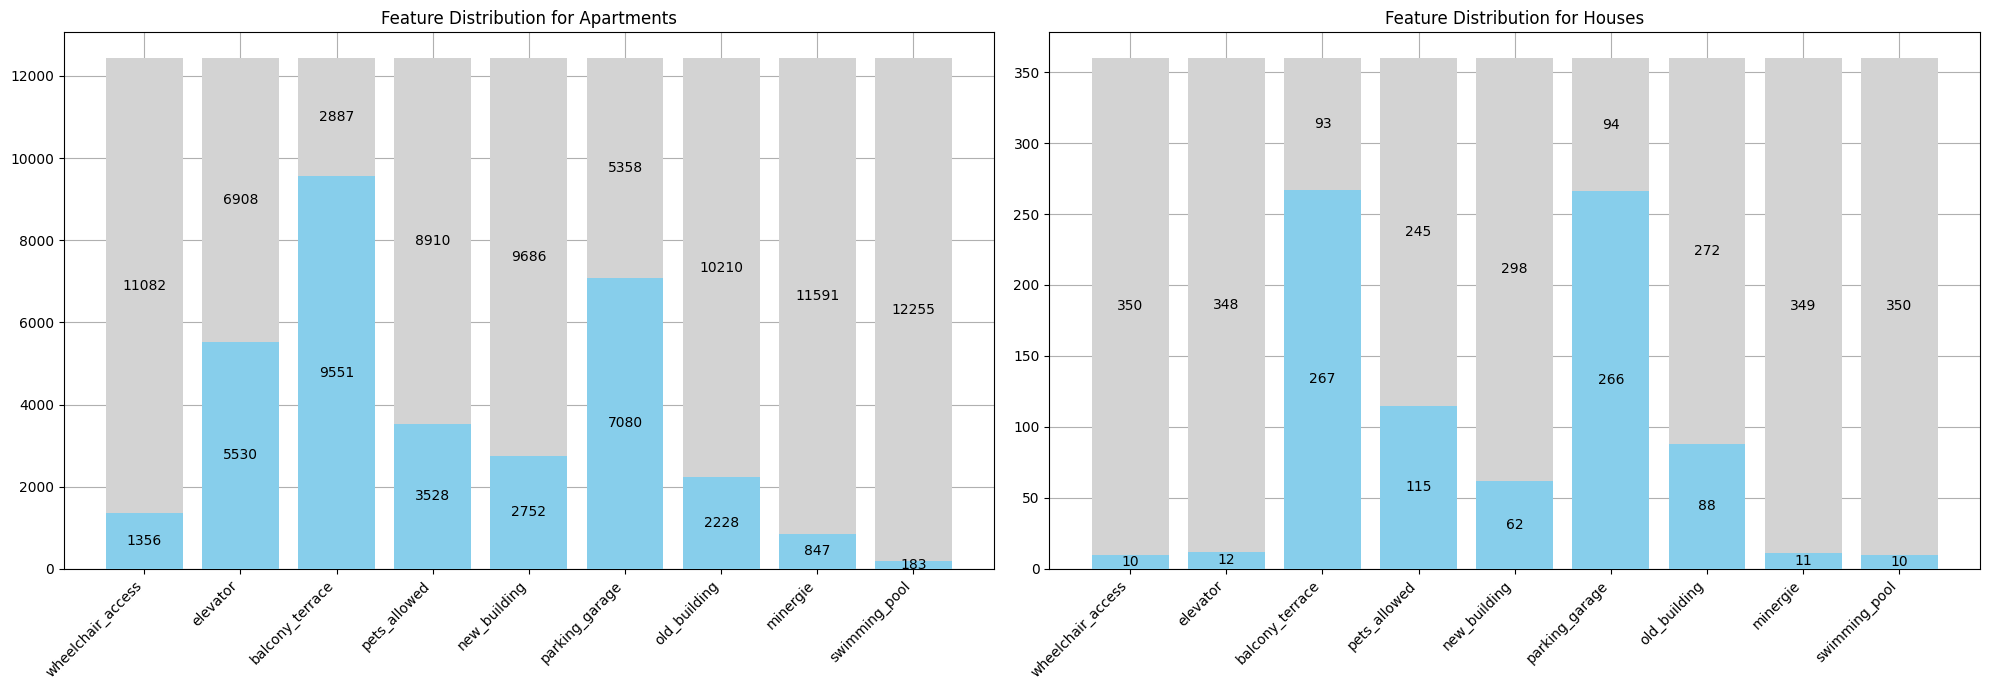

In [38]:
# Filter the DataFrame for apartments and houses
df_apartments = df[df["type"] == "Apartment"]
df_houses = df[df["type"] == "House"]

# List of features to plot
features = [
    "wheelchair_access",
    "elevator",
    "balcony_terrace",
    "pets_allowed",
    "new_building",
    "parking_garage",
    "old_building",
    "minergie",
    "swimming_pool"
]

# Function to count occurrences of True and False for each feature
def count_features(df, features):
    counts = {}
    for feature in features:
        counts[feature] = df[feature].value_counts().reindex([True, False], fill_value=0)
    return counts

# Count occurrences for apartments and houses
counts_apartments = count_features(df_apartments, features)
counts_houses = count_features(df_houses, features)

# Create stacked bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot for apartments
ax = axes[0]
for feature in features:
    yes_count = counts_apartments[feature][True]
    no_count = counts_apartments[feature][False]
    ax.bar(feature, yes_count, label='Yes' if feature == features[0] else "", color='skyblue', zorder=10)
    ax.bar(feature, no_count, bottom=yes_count, label='No' if feature == features[0] else "", color='lightgrey', zorder=10)
    ax.annotate(f'{yes_count}', xy=(feature, yes_count / 2), ha='center', va='center', color='black', zorder=20)
    ax.annotate(f'{no_count}', xy=(feature, yes_count + no_count / 2), ha='center', va='center', color='black', zorder=20)

ax.set_title('Feature Distribution for Apartments')
ax.grid(True, zorder=0)
ax.set_xticklabels(features, rotation=45, ha='right')

# Plot for houses
ax = axes[1]
for feature in features:
    yes_count = counts_houses[feature][True]
    no_count = counts_houses[feature][False]
    ax.bar(feature, yes_count, label='Yes' if feature == features[0] else "", color='skyblue', zorder=10)
    ax.bar(feature, no_count, bottom=yes_count, label='No' if feature == features[0] else "", color='lightgrey', zorder=10)
    ax.annotate(f'{yes_count}', xy=(feature, yes_count / 2), ha='center', va='center', color='black', zorder=20)
    ax.annotate(f'{no_count}', xy=(feature, yes_count + no_count / 2), ha='center', va='center', color='black', zorder=20)

ax.set_title('Feature Distribution for Houses')
ax.grid(True, zorder=0)
ax.set_xticklabels(features, rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

I believe that if you live in a house, you don't have wheelchair access or elevator. 

Appartments have elevators and are newer and more eco friendly.

Houses have more parking garage and are older. 

## 3.2 Features importance
We have a dataframe with 17 features. I wonder if they are all usefull. 

Indeed, some features like `swimming_pool` appears only a few times and probably does not have much importance as a feature for training. 

I decided to train a `RandomForestRegressor` to find out the importance of each features to see if we could discard some of them for training a model.

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_64080/1170026995.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols] = X[bool_cols].astype(int)


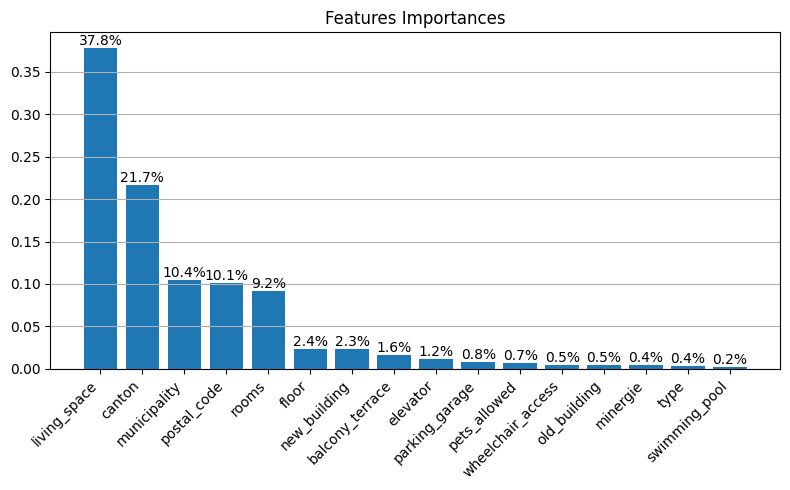

In [19]:
# define features and target
features = df.columns.tolist()
features.remove("rent")
target = "rent"

X = df[features]
y = df[target]

# Convert booleans to integers
bool_cols = [
  "wheelchair_access", "elevator", "balcony_terrace", 
  "pets_allowed", "new_building", "parking_garage", 
  "old_building", "minergie", "swimming_pool"
]
X[bool_cols] = X[bool_cols].astype(int)

# One-hot encode categorical
cat_cols = ["type", "canton", "municipality", "postal_code"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numerical features
num_cols = ["rooms", "living_space", "floor"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract and sort feature importances
importances = model.feature_importances_
feature_names = X.columns

group_prefixes = {
  "type_": "type",
  "canton_": "canton",
  "municipality_": "municipality",
  "postal_code_": "postal_code"
}

# Create a dictionary to accumulate importance sums
grouped_importances = defaultdict(float)

for i, col in enumerate(feature_names):
  matched_group = None
  for prefix, group_name in group_prefixes.items():
    if col.startswith(prefix):
      grouped_importances[group_name] += importances[i]
      matched_group = group_name
      break
  
  if not matched_group:
    # Column doesn't match any prefix, keep it by its original name
    grouped_importances[col] += importances[i]

# Convert the dictionary to lists for plotting
group_names = list(grouped_importances.keys())
group_values = [grouped_importances[g] for g in group_names]

# Sort groups by importance (descending)
sorted_indices = np.argsort(group_values)[::-1]
group_names_sorted = [group_names[i] for i in sorted_indices]
group_values_sorted = [group_values[i] for i in sorted_indices]

# Plot the grouped feature importances
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(group_names_sorted)), group_values_sorted)
plt.xticks(range(len(group_names_sorted)), group_names_sorted, rotation=45, ha='right')

# Add grid on y-axis
plt.grid(axis='y')

# Add percentage labels on top of each bar
total_importance = sum(group_values_sorted)
for i, val in enumerate(group_values_sorted):
  pct = (val / total_importance) * 100
  plt.text(i, val, f"{pct:.1f}%", ha='center', va='bottom')

plt.title("Features Importances")
plt.tight_layout()
plt.show()

We can see that the most important features are: 
- Living space
- Canton
- Municipality
- Postal Code
- Rooms 

The feature `floor` does not have much importance. 

The feature `type` which tells if this is an appartment or house does not matter at all !

All the boolean features don't have that much importance.

For training, we will only keep the following features: 
- living_space
- canton
- postal_code
- rooms

We don't keep `municipality` as it's the same feature as `postal_code`.

We don't keep the others features as well.

## 3.3 Clustering
I decided to do some unsupervised learning using knn. 

I wanted to see if knn could group all our listing with similar features.

Let's see.

/opt/homebrew/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


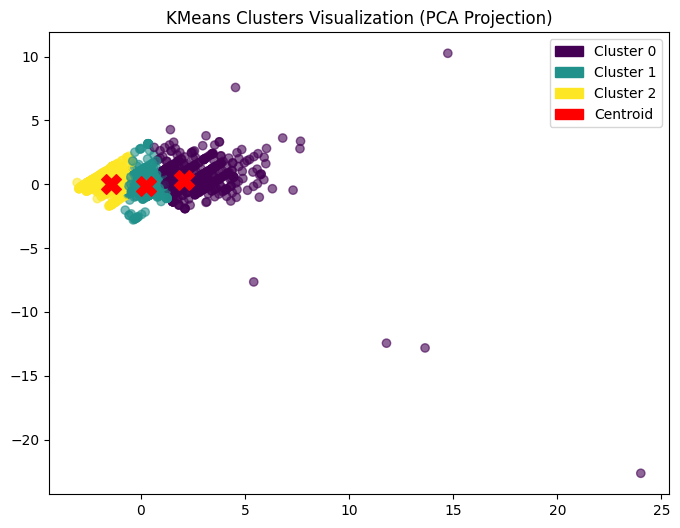

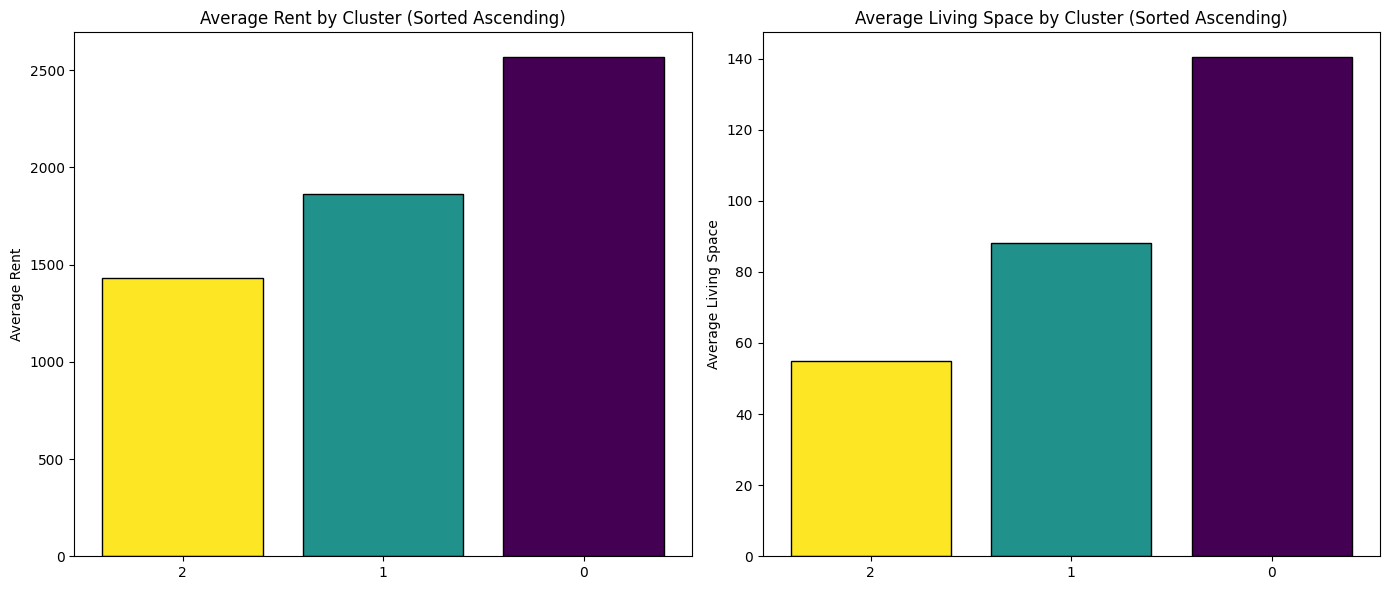

In [31]:
# Prepare the features and target
X = df[["living_space", "rooms", "canton", "postal_code"]]
y = df["rent"]

# One-hot encode categorical columns
cat_cols = ["canton", "postal_code"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numerical features
num_cols = ["living_space", "rooms"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
)

# Fit KMeans on the training data
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train)

# Compute the average rent for each cluster (for baseline prediction)
cluster_rents = {}
for cluster in range(n_clusters):
  cluster_rents[cluster] = y_train[train_clusters == cluster].mean()

# Visualize clusters using PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
centers_2d = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
                      c=train_clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
            c='red', marker='X', s=200, label='Centroids')
plt.title('KMeans Clusters Visualization (PCA Projection)')

# Create custom legend patches for clusters
patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i}") 
           for i in range(n_clusters)]
patches.append(mpatches.Patch(color='red', label='Centroid'))
plt.legend(handles=patches)
plt.show()

# additional plot with the average rent for each cluster

# Extract the original values for 'living_space', 'rent', and 'canton'
# using the training indices.
df_train = df.loc[X_train.index].copy()
df_train['cluster'] = train_clusters

# Define colors for each cluster using the same viridis colormap
if n_clusters > 1:
  cluster_colors = [plt.cm.viridis(i/(n_clusters-1)) for i in range(n_clusters)]
else:
  cluster_colors = [plt.cm.viridis(0)]

# Define a mapping for cluster colors using the same viridis colormap
cluster_color_mapping = {i: plt.cm.viridis(i/(n_clusters-1)) for i in range(n_clusters)}

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Average Rent by Cluster (sorted ascending)
avg_rent = df_train.groupby('cluster')['rent'].mean().sort_values(ascending=True)
axs[0].bar(avg_rent.index.astype(str), avg_rent, 
           color=[cluster_color_mapping[i] for i in avg_rent.index], edgecolor='black')
axs[0].set_title('Average Rent by Cluster (Sorted Ascending)')
axs[0].set_ylabel('Average Rent')

# Plot 2: Average Living Space by Cluster (sorted ascending)
avg_living_space = df_train.groupby('cluster')['living_space'].mean().sort_values(ascending=True)
axs[1].bar(avg_living_space.index.astype(str), avg_living_space, 
           color=[cluster_color_mapping[i] for i in avg_living_space.index], edgecolor='black')
axs[1].set_title('Average Living Space by Cluster (Sorted Ascending)')
axs[1].set_ylabel('Average Living Space')

plt.tight_layout()
plt.show()

As we can see, we have 3 differents clusters:
- yellow
- turquoise
- purple

The 2 last plots are the average rent and living space for each cluster. 

I then make the following assumption: 
- cluster yellow => cheap appartment
- cluster turquoise => medium appartment
- cluster purple => expensive appartment

The cheap and medium cluster are thightly grouped. I believe that if you have a "normal" salary, there is a small range of rent that you can afford.

However, if you have a lot of money, you can afford very expensive appartments as the listings for them are more scattered. 
Don't forget that I also removed all the expensive outliers.

## 3.4 Multiple Linear Regression baseline
We're going to train a linear regression as a baseline.

In [20]:
X = df[["living_space", "rooms", "canton", "postal_code"]]
y = df["rent"]

# One-hot encode categorical columns
cat_cols = ["canton", "postal_code"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric features
num_cols = ["living_space", "rooms"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
)

X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

# Instantiate the model
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Predict on test data
linreg_y_pred = linreg.predict(X_test)

# Evaluate
linreg_mse = mean_squared_error(y_test, linreg_y_pred)
linreg_r2 = r2_score(y_test, linreg_y_pred)

print("Multiple Linear Regression Results:")
print(f"  MSE: {linreg_mse:.4f}")
print(f"  R^2: {linreg_r2:.4f}")

Multiple Linear Regression Results:
  MSE: 179672.9375
  R^2: 0.5884


## 3.5 XGBoost baseline
We're going to train a XGBoost regressor as a second baseline.

In [21]:
X = df[["living_space", "rooms", "canton", "postal_code"]]
y = df["rent"]

# One-hot encode categorical columns
cat_cols = ["canton", "postal_code"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric features
num_cols = ["living_space", "rooms"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
)

X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

# Instantiate the model with default hyperparameters
xgb_model = XGBRegressor(random_state=42)

# Fit on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print("\nXGBoost Regressor Results:")
print(f"  MSE: {xgb_mse:.4f}")
print(f"  R^2: {xgb_r2:.4f}")


XGBoost Regressor Results:
  MSE: 146190.7500
  R^2: 0.6651


This is the baseline we need to beat with out deep learning model.

## 3.6 Custom trained deep learning regressor using PyTorch
The baseline to beat is XGBoost with a R2 value of **0.6651**.

I first try to train a really simple model with a few neurons and no hyperparameters tuning and I end up with a performance between Linear Regression and XGBoost.

My goal for this model is to beat XG-Boost R2 performance. I then had to spend some time tweaking all the parameters of my neural network.

In order to beat XG-Boost I made the following tuning: 
- I randomly tried differents neurons width and depth to see theirs performance
  - I have 3 hidden layers with 103, 290 and 171 neurons
  - going deeper decrease performance
  - going wider does not increase performance
- I added Batch normalization and random dropout
- I used ReLu activation function, leaky_relu does not improve performance
- I applied a learning rate of 0.00095 and a weight_decay of 0.0002
- every 2 steps, I decrease learning rate at 85% of its previous value
- I train for 500 epoch and early stop if it has not improved after 10 epochs

Let's see.


Epoch [1/500], Train Loss: 3711755.2922, Val Loss: 3557120.0750
Epoch [2/500], Train Loss: 3314382.5988, Val Loss: 3064846.4062
Epoch [3/500], Train Loss: 2743351.7164, Val Loss: 2460418.7250
Epoch [4/500], Train Loss: 2169716.4496, Val Loss: 1816833.8859
Epoch [5/500], Train Loss: 1666325.7186, Val Loss: 1505022.1406
Epoch [6/500], Train Loss: 1267993.6633, Val Loss: 1090887.8820
Epoch [7/500], Train Loss: 958137.8589, Val Loss: 891686.7945
Epoch [8/500], Train Loss: 738192.2922, Val Loss: 638768.2793
Epoch [9/500], Train Loss: 584127.9801, Val Loss: 536126.7914
Epoch [10/500], Train Loss: 467133.2960, Val Loss: 377428.1047
Epoch [11/500], Train Loss: 371146.1159, Val Loss: 366206.6898
Epoch [12/500], Train Loss: 281331.3373, Val Loss: 238439.3897
Epoch [13/500], Train Loss: 218570.8752, Val Loss: 198383.3642
Epoch [14/500], Train Loss: 183611.7307, Val Loss: 183017.5790
Epoch [15/500], Train Loss: 159225.7723, Val Loss: 163687.9170
Epoch [16/500], Train Loss: 141060.8700, Val Loss: 1

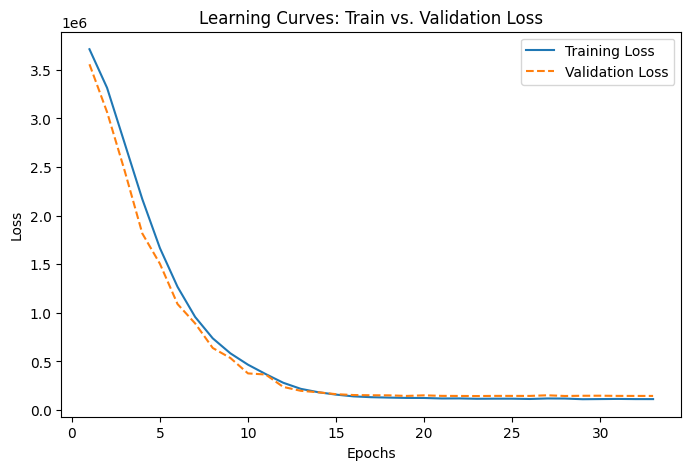

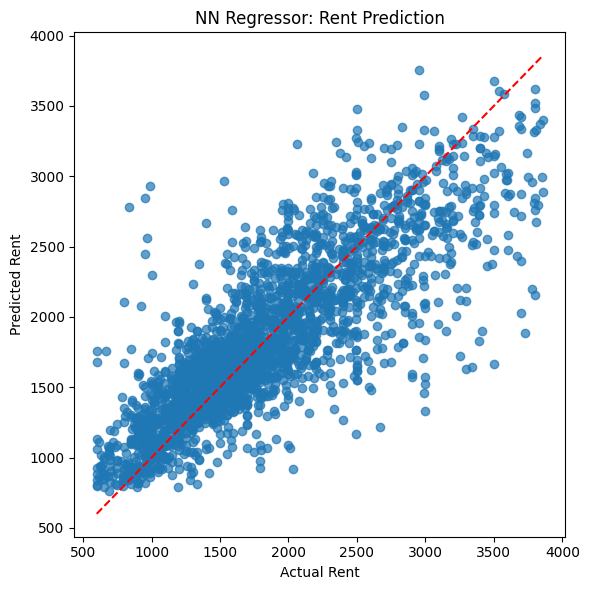

In [30]:
X = df[["living_space", "rooms", "canton", "postal_code"]]
y = df["rent"]

cat_cols = ["canton", "postal_code"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

num_cols = ["living_space", "rooms"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

class RentDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
train_dataset = RentDataset(X_train, y_train)
test_dataset  = RentDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# Define the model 
class RentRegressor(nn.Module):
  def __init__(self, input_dim):
    super(RentRegressor, self).__init__()
    self.fc1 = nn.Linear(input_dim, 103)
    self.bn1 = nn.BatchNorm1d(103)
    self.drop1 = nn.Dropout(0.3)

    self.fc2 = nn.Linear(103, 290)
    self.bn2 = nn.BatchNorm1d(290)
    self.drop2 = nn.Dropout(0.3)

    self.fc3 = nn.Linear(290, 171)
    self.bn3 = nn.BatchNorm1d(171)
    self.drop3 = nn.Dropout(0.3)

    self.fc4 = nn.Linear(171, 1)
  
  def forward(self, x):
    x = nn.functional.relu(self.bn1(self.fc1(x)))
    x = self.drop1(x)

    x = nn.functional.relu(self.bn2(self.fc2(x)))
    x = self.drop2(x)

    x = nn.functional.relu(self.bn3(self.fc3(x)))
    x = self.drop3(x) 

    return self.fc4(x)
  
input_dim = X_train.shape[1]
model = RentRegressor(input_dim)

# tune hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.00095, weight_decay=0.0002) # weight_decay=0.0001 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.85)
criterion = nn.MSELoss()

num_epochs = 500
train_losses = []
val_losses = []
best_val_loss = float("inf")
early_stop_counter = 0
patience = 10

for epoch in range(num_epochs):
  model.train()
  epoch_train_loss = 0.0
  
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    preds = model(batch_X).squeeze()
    loss = criterion(preds, batch_y)
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()
  
  epoch_train_loss /= len(train_loader)
  train_losses.append(epoch_train_loss)

  # Validate model
  model.eval()
  epoch_val_loss = 0.0
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      preds = model(batch_X).squeeze()
      loss = criterion(preds, batch_y)
      epoch_val_loss += loss.item()

  epoch_val_loss /= len(test_loader)
  val_losses.append(epoch_val_loss)

  scheduler.step()

  # Early stopping
  if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    early_stop_counter = 0  # Reset counter
  else:
    early_stop_counter += 1
    if early_stop_counter >= patience:
      print(f"Early stopping at epoch {epoch + 1}")
      break
  
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Evaluate Performance
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
  for batch_X, batch_y in test_loader:
    preds = model(batch_X).squeeze()
    all_preds.append(preds.numpy())
    all_targets.append(batch_y.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"Test MSE: {mse:.4f}")
print(f"Test R^2: {r2:.4f}")

# Plot Learning Curves to Detect Overfitting
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", linestyle="dashed")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves: Train vs. Validation Loss")
plt.show()

# Plot Actual vs. Predicted Rent Prices 
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.7)

y_min = min(all_targets.min(), all_preds.min())
y_max = max(all_targets.max(), all_preds.max())
plt.plot([y_min, y_max], [y_min, y_max], 'r--')

plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("NN Regressor: Rent Prediction")
plt.tight_layout()
plt.show()

Nice we have a r2 value of **0.6660** which slighty beats XGBoost performance !

If I take a look at both loss values over epoch, we can see that the validation loss is slightly lower that the training loss suggesting that there is underfitting. 

They look quite close but I don't know how much underfitted the model is.

During my experiments, I found that adding regularizatiom dropout, scheduler helps reducing the overfitting. 

## 3.7 Rent simulator

The research question was: **How much am I going to pay for my next appartment ???**

Let's find out:

In [ ]:
def predict_rent(model, kmeans, living_space, rooms, canton, postal_code, scaler, X_columns, known_cantons, known_postal_codes):
  # Create a DataFrame for the input
  input_data = pd.DataFrame(
      [[living_space, rooms, canton, postal_code]], 
      columns=["living_space", "rooms", "canton", "postal_code"]
  )
  
  # One-hot encode categorical features efficiently
  canton_encoded = {f"canton_{c}": int(canton == c) for c in known_cantons}
  postal_code_encoded = {f"postal_code_{p}": int(postal_code == p) for p in known_postal_codes}
  
  # Convert encoding dictionaries to DataFrame and concatenate
  encoding_df = pd.DataFrame([canton_encoded | postal_code_encoded])
  input_data = pd.concat([input_data, encoding_df], axis=1)
  
  # Drop original categorical columns
  input_data.drop(columns=["canton", "postal_code"], inplace=True)
  
  # Normalize numerical features
  input_data[["living_space", "rooms"]] = scaler.transform(input_data[["living_space", "rooms"]])
  
  # Ensure the order of features matches training data
  input_data = input_data.reindex(columns=X_columns, fill_value=0).copy()

  predicted_class = kmeans.predict(input_data)[0]
  predicted_class = "Cheap" if predicted_class == 0 else "Expensive" if predicted_class == 1 else "Medium"

  # Convert to tensor
  input_tensor = torch.tensor(input_data.values, dtype=torch.float32)
  
  # Predict rent
  model.eval()
  with torch.no_grad():
    predicted_rent = model(input_tensor).item()
  
  return {
    "rent": predicted_rent,
    "class": predicted_class
  }

#####################################
# Fill the variables with your data #
#####################################
canton = "Vaud"
postal_code = 1000
living_space = 75
rooms = 3.5

predicted_rent = predict_rent(
  model, 
  kmeans,
  living_space=living_space, 
  rooms=rooms, 
  canton=canton, 
  postal_code=postal_code, 
  scaler=scaler, 
  X_columns=X_train.columns, 
  known_cantons=df["canton"].unique(), 
  known_postal_codes=df["postal_code"].unique()
)

print(f"### Super Swiss Rent estimator 2000 ##")
print(f"Canton: {canton}")  
print(f"Postal Code: {postal_code}")
print(f"Living Space: {living_space} m²")
print(f"Rooms: {rooms}")
print()
print(f"Predicted Class: {predicted_rent["class"]} price appartment/house")
print(f"Predicted Rent: {predicted_rent["rent"]:.2f} CHF")

  

### Super Swiss Rent estimator 2000 ##
Canton: Vaud
Postal Code: 1000
Living Space: 75 m²
Rooms: 3.5

Predicted Class: Expensive price appartment/house
Predicted Rent: 2409.07 CHF
